In [1]:
# data driven packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import ImageColor

# plotting packages
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import plotnine
from plotnine import *

# cluster packages
from kmodes.kprototypes import KPrototypes

# use importance plot
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

# file copy-arrange
import shutil

작업 경로 설정
데이터 불러오기

In [2]:
os.chdir(r'C:\Users\styli\Desktop\github_repository_add\OneStore_webtoon_img_cluster')
data = pd.read_csv('webtoon_top5col.csv')

데이터 형태 확인

In [3]:
data.head()

,제목,카테고리,hex1,hex2,hex3,hex4,hex5,hex1rate,hex2rate,hex3rate,hex4rate,hex5rate,file_path
0,4와 2분의 1 정거장,BL,#fefcf7,#fcd2cf,#fa8263,#f6ae9d,#dd3435,0.362742,0.254111,0.181476,0.106669,0.095002,4와 2분의 1 정거장.jpg
1,BL의 정석,BL,#e5e8e9,#3294c2,#282b2e,#6a6f73,#b6b7b9,0.595297,0.128252,0.106436,0.085562,0.084453,BL의 정석.jpg
2,Not so bad(낫 소 배드),BL,#fdf6f1,#301632,#f3d9c4,#693560,#b68293,0.538033,0.174916,0.169953,0.064639,0.052458,Not so bad(낫 소 배드).jpg
3,Take on Me,BL,#f2f5f1,#f0c9c2,#d4898d,#914a5d,#431c27,0.550254,0.149492,0.129461,0.092122,0.078671,Take on Me.jpg
4,[BL] 새비지 가든 [일반판],BL,#fdf8f0,#65504d,#a39796,#e1c3ae,#251916,0.323965,0.282766,0.149054,0.134914,0.109301,[BL] 새비지 가든 [일반판].jpg


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   제목         1107 non-null   object 
 1   카테고리       1107 non-null   object 
 2   hex1       1107 non-null   object 
 3   hex2       1107 non-null   object 
 4   hex3       1107 non-null   object 
 5   hex4       1107 non-null   object 
 6   hex5       1107 non-null   object 
 7   hex1rate   1107 non-null   float64
 8   hex2rate   1107 non-null   float64
 9   hex3rate   1107 non-null   float64
 10  hex4rate   1107 non-null   float64
 11  hex5rate   1107 non-null   float64
 12  file_path  1107 non-null   object 
dtypes: float64(5), object(8)
memory usage: 112.6+ KB


hex1 ~ hex5는 색깔 분포의 순위를 의미하고
hex1rate는 해당번째 순위의 정도를 의미하고 있다.

NN은 비지도 학습에 좋지 못하므로 제외
카테고리는 범주형 자료이니 군집화시 유의
hexcode는 rgb형으로 바꾸어 분석을 실시하여야 할 것.

RGB형은 다음과 같이 변형이 가능하다.

In [5]:
print(f'hex code : {data.hex1[0]} , rgb : {ImageColor.getcolor(data.hex1[0], "RGB")} ')
a, b, c = ImageColor.getcolor(data.hex1[0], "RGB")
print(f'정규화 rgb : {a/255, b/255, c/255}')

hex code : #fefcf7 , rgb : (254, 252, 247) 
정규화 rgb : (0.996078431372549, 0.9882352941176471, 0.9686274509803922)


혹은 다음과 같이 변형이 가능하다.
사실 to_rgb는 모르는 사용법이라 한번 결과체크하는 과정때문에 사용함.

k-mean 과정에는 스케일링을 같게 해주는 과정이 필요하므로, 이 변환이 더 올바르다고 판단하였다.

In [6]:
to_rgb(data.hex1[0])

(0.996078431372549, 0.9882352941176471, 0.9686274509803922)

비효율적이긴 한데 효율적인 생각이 바로 안나니까, 그냥 이대로 구현함.

In [7]:
import matplotlib
from PIL import ImageColor

hex1 = np.array([matplotlib.colors.rgb_to_hsv(ImageColor.getcolor(line, "RGB")) for line in data.hex1])
hex2 = np.array([matplotlib.colors.rgb_to_hsv(ImageColor.getcolor(line, "RGB")) for line in data.hex2])
hex3 = np.array([matplotlib.colors.rgb_to_hsv(ImageColor.getcolor(line, "RGB")) for line in data.hex3])
hex4 = np.array([matplotlib.colors.rgb_to_hsv(ImageColor.getcolor(line, "RGB")) for line in data.hex4])
hex5 = np.array([matplotlib.colors.rgb_to_hsv(ImageColor.getcolor(line, "RGB")) for line in data.hex5])

#hex2 = np.array([to_rgb(line) for line in data.hex2])
#hex3 = np.array([to_rgb(line) for line in data.hex3])
#hex4 = np.array([to_rgb(line) for line in data.hex4])
#hex5 = np.array([to_rgb(line) for line in data.hex5])

HLS 좌표에서 RGB 좌표로 색을 변환합니다.

RGB값으로 분석을 진행하니, 명도 채도만 유사성으로 학습하였다. 따라서 HSV 변환을 통해, 색상, 명도 채도를 표현하겠다.

In [8]:
hex_arr = np.concatenate((hex1, hex2, hex3, hex4, hex5),axis=1)

In [9]:
hex_arr[:5]

array([[1.19047619e-01, 2.75590551e-02, 2.54000000e+02, 1.11111111e-02,
        1.78571429e-01, 2.52000000e+02, 3.42163355e-02, 6.04000000e-01,
        2.50000000e+02, 3.18352060e-02, 3.61788618e-01, 2.46000000e+02,
        9.99013807e-01, 7.64705882e-01, 2.21000000e+02],
       [5.41666667e-01, 1.71673820e-02, 2.33000000e+02, 5.53240741e-01,
        7.42268041e-01, 1.94000000e+02, 5.83333333e-01, 1.30434783e-01,
        4.60000000e+01, 5.74074074e-01, 7.82608696e-02, 1.15000000e+02,
        6.11111111e-01, 1.62162162e-02, 1.85000000e+02],
       [6.94444444e-02, 4.74308300e-02, 2.53000000e+02, 8.21428571e-01,
        5.60000000e-01, 5.00000000e+01, 7.44680851e-02, 1.93415638e-01,
        2.43000000e+02, 8.62179487e-01, 4.95238095e-01, 1.05000000e+02,
        9.45512821e-01, 2.85714286e-01, 1.82000000e+02],
       [2.91666667e-01, 1.63265306e-02, 2.45000000e+02, 2.53623188e-02,
        1.91666667e-01, 2.40000000e+02, 9.91111111e-01, 3.53773585e-01,
        2.12000000e+02, 9.55399061e-0

In [10]:
hex_arr = hex_arr / 255

hsv값을 임포트 하였다. h, s, v값은 전처리 실시하였음. -> / 255

In [11]:
hsv_col_lab = ['hex1h', 'hex1s', 'hex1v', 'hex2h', 'hex2s', 'hex2v', 'hex3h', 'hex3s', 'hex3v',
               'hex4h', 'hex4s', 'hex4v', 'hex5h', 'hex5s', 'hex5v',]
hsv_data = pd.DataFrame(hex_arr, columns = hsv_col_lab)

RGB 값 변화한 데이터를, data에 결합해준다.
이하 데이터셋을 분석 기본 세트로 정의함.

In [12]:
hsv_data.head()

,hex1h,hex1s,hex1v,hex2h,hex2s,hex2v,hex3h,hex3s,hex3v,hex4h,hex4s,hex4v,hex5h,hex5s,hex5v
0,0.000467,0.000108,0.996078,0.000044,0.000700,0.988235,0.000134,0.002369,0.980392,0.000125,0.001419,0.964706,0.003918,0.002999,0.866667
1,0.002124,0.000067,0.913725,0.002170,0.002911,0.760784,0.002288,0.000512,0.180392,0.002251,0.000307,0.450980,0.002397,0.000064,0.725490
2,0.000272,0.000186,0.992157,0.003221,0.002196,0.196078,0.000292,0.000758,0.952941,0.003381,0.001942,0.411765,0.003708,0.001120,0.713725
3,0.001144,0.000064,0.960784,0.000099,0.000752,0.941176,0.003887,0.001387,0.831373,0.003747,0.001920,0.568627,0.003737,0.002283,0.262745
4,0.000402,0.000202,0.992157,0.000082,0.000932,0.396078,0.000050,0.000313,0.639216,0.000269,0.000889,0.882353,0.000131,0.001590,0.145098


In [13]:
data = pd.concat([data, hsv_data], axis = 1)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   제목         1107 non-null   object 
 1   카테고리       1107 non-null   object 
 2   hex1       1107 non-null   object 
 3   hex2       1107 non-null   object 
 4   hex3       1107 non-null   object 
 5   hex4       1107 non-null   object 
 6   hex5       1107 non-null   object 
 7   hex1rate   1107 non-null   float64
 8   hex2rate   1107 non-null   float64
 9   hex3rate   1107 non-null   float64
 10  hex4rate   1107 non-null   float64
 11  hex5rate   1107 non-null   float64
 12  file_path  1107 non-null   object 
 13  hex1h      1107 non-null   float64
 14  hex1s      1107 non-null   float64
 15  hex1v      1107 non-null   float64
 16  hex2h      1107 non-null   float64
 17  hex2s      1107 non-null   float64
 18  hex2v      1107 non-null   float64
 19  hex3h      1107 non-null   float64
 20  hex3s   

In [15]:
data.head()

,제목,카테고리,hex1,hex2,hex3,hex4,hex5,hex1rate,hex2rate,hex3rate,...,hex2v,hex3h,hex3s,hex3v,hex4h,hex4s,hex4v,hex5h,hex5s,hex5v
0,4와 2분의 1 정거장,BL,#fefcf7,#fcd2cf,#fa8263,#f6ae9d,#dd3435,0.362742,0.254111,0.181476,...,0.988235,0.000134,0.002369,0.980392,0.000125,0.001419,0.964706,0.003918,0.002999,0.866667
1,BL의 정석,BL,#e5e8e9,#3294c2,#282b2e,#6a6f73,#b6b7b9,0.595297,0.128252,0.106436,...,0.760784,0.002288,0.000512,0.180392,0.002251,0.000307,0.450980,0.002397,0.000064,0.725490
2,Not so bad(낫 소 배드),BL,#fdf6f1,#301632,#f3d9c4,#693560,#b68293,0.538033,0.174916,0.169953,...,0.196078,0.000292,0.000758,0.952941,0.003381,0.001942,0.411765,0.003708,0.001120,0.713725
3,Take on Me,BL,#f2f5f1,#f0c9c2,#d4898d,#914a5d,#431c27,0.550254,0.149492,0.129461,...,0.941176,0.003887,0.001387,0.831373,0.003747,0.001920,0.568627,0.003737,0.002283,0.262745
4,[BL] 새비지 가든 [일반판],BL,#fdf8f0,#65504d,#a39796,#e1c3ae,#251916,0.323965,0.282766,0.149054,...,0.396078,0.000050,0.000313,0.639216,0.000269,0.000889,0.882353,0.000131,0.001590,0.145098


데이터셋의 형태도 그대로 유지되었고
표준화 완료된 값으로 RGB 값을 반환하였다.

일단 가능한지 보기 위해. 카테고리, hex1-5(rgb값), hex1-5 rate를 k-prototype에 적용시킨다.

카테고리 함수 하나 때문에 UMAP을 사용했기 때문에, 그래프는 매 실행마다 다르게 나온다. 막으려먼, fit, umap 등에서 모두 seed 고정하고
random.seed, np.seed, tf.seed의 고정도 필요.

## 차후에 확인 작업 필요하다. rgb값만 넣고 k-prototype 돌린결과가 더 양호한지, 3개의 색만 넣은게 양호한지. 등등 여러가지 경우의 수를 확인해야 한다.

In [16]:
protodata = data.drop(['제목','hex1','hex2','hex3','hex4','hex5','file_path','hex1rate','hex2rate','hex3rate','hex4rate','hex5rate'],axis = 1)
protodata.head()

,카테고리,hex1h,hex1s,hex1v,hex2h,hex2s,hex2v,hex3h,hex3s,hex3v,hex4h,hex4s,hex4v,hex5h,hex5s,hex5v
0,BL,0.000467,0.000108,0.996078,0.000044,0.000700,0.988235,0.000134,0.002369,0.980392,0.000125,0.001419,0.964706,0.003918,0.002999,0.866667
1,BL,0.002124,0.000067,0.913725,0.002170,0.002911,0.760784,0.002288,0.000512,0.180392,0.002251,0.000307,0.450980,0.002397,0.000064,0.725490
2,BL,0.000272,0.000186,0.992157,0.003221,0.002196,0.196078,0.000292,0.000758,0.952941,0.003381,0.001942,0.411765,0.003708,0.001120,0.713725
3,BL,0.001144,0.000064,0.960784,0.000099,0.000752,0.941176,0.003887,0.001387,0.831373,0.003747,0.001920,0.568627,0.003737,0.002283,0.262745
4,BL,0.000402,0.000202,0.992157,0.000082,0.000932,0.396078,0.000050,0.000313,0.639216,0.000269,0.000889,0.882353,0.000131,0.001590,0.145098


k-prototype은 카테고리는 object형, 수치형은 k-mean 기반이기에 표준화가 이뤄져야한다.
본 코드에서는 정규화로 계산되었다.

In [17]:
protodata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    1107 non-null   object 
 1   hex1h   1107 non-null   float64
 2   hex1s   1107 non-null   float64
 3   hex1v   1107 non-null   float64
 4   hex2h   1107 non-null   float64
 5   hex2s   1107 non-null   float64
 6   hex2v   1107 non-null   float64
 7   hex3h   1107 non-null   float64
 8   hex3s   1107 non-null   float64
 9   hex3v   1107 non-null   float64
 10  hex4h   1107 non-null   float64
 11  hex4s   1107 non-null   float64
 12  hex4v   1107 non-null   float64
 13  hex5h   1107 non-null   float64
 14  hex5s   1107 non-null   float64
 15  hex5v   1107 non-null   float64
dtypes: float64(15), object(1)
memory usage: 138.5+ KB


UMAP Embedding 작업.
numerical의 전처리는 이미 정규화 되었기에 실시하지 않는다.

In [18]:
#Preprocessing numerical
numerical = protodata.select_dtypes(exclude='object')

##preprocessing categorical
categorical = protodata.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(protodata.select_dtypes(include='object').columns) / protodata.shape[1]
print(f'전체에서 범주형 데이터 비중 : {categorical_weight}')

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

전체에서 범주형 데이터 비중 : 0.0625


C:\Users\styli\anaconda3\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable


임베딩 후 그래프 그리기.

In [19]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)

embedding = umap.umap_.simplicial_set_embedding(data=fit1._raw_data, graph=intersection, n_components=fit1.n_components,
                                                initial_alpha=fit1._initial_alpha, a=fit1._a, b=fit1._b,
                                                gamma=fit1.repulsion_strength, negative_sample_rate=fit1.negative_sample_rate,
                                                n_epochs=500, init = 'random', random_state = np.random, metric = fit1.metric,
                                                metric_kwds= fit1._metric_kwds, densmap = False, densmap_kwds=False, output_dens=False, verbose=1)

  0%|          | 0/500 [00:00<?, ?it/s]

플롯을 출력한다

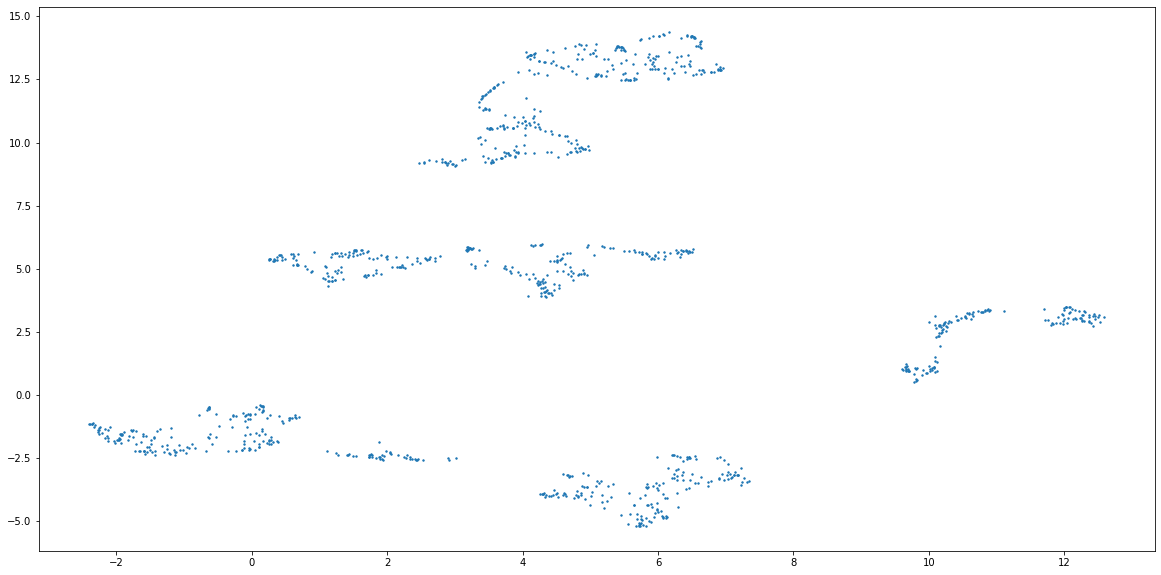

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(embedding[0][:, 0], embedding[0][:, 1],s=2, cmap='Spectral', alpha=1.0)
plt.show()

좋은 모양일까?, 좋은 모양이더라도 UMAP이기에 항상 이모양이라고 가정할 수 없기 때문에 잘 모른다.
또한 클러스터링 된 결과가 그래프의 모양과 일치하지 않을수도 있다.


일단 그래프 작업은 여기까지 진행하고, prototype을 돌리기 위한 사전작업을 진행한다.

In [21]:
categorical_columns = [protodata.columns.get_loc(col) for col in list(protodata.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(protodata.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(categorical_columns))

Categorical columns           : ['카테고리']
Categorical columns position  : [0]


원래라면, k=8정도에서 멈출것이지만, 열이 상당히 많음으로
또한 분류 해야할 범위가 크다고 판단하여, 16까지 진행하였다.

또한 scree plot은 결과를 고정하는것이 좋으므로 seed를 임의로 고정하여 그렸다.

In [22]:
# Choose optimal K using Elbow method
cost = []
for cluster in tqdm(range(1, 17)):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 404, verbose = 1)
        kprototype.fit_predict(protodata, categorical = categorical_columns)
        cost.append(kprototype.cost_)
        print(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

  6%|▋         | 1/16 [00:07<01:55,  7.73s/it]

Best run was number 1
594.4759559289413
Cluster initiation: 1


 12%|█▎        | 2/16 [00:11<01:12,  5.18s/it]

Best run was number 10
458.92231033405585
Cluster initiation: 2


 19%|█▉        | 3/16 [00:17<01:12,  5.58s/it]

Best run was number 3
392.48340062288804
Cluster initiation: 3


 25%|██▌       | 4/16 [00:22<01:07,  5.60s/it]

Best run was number 6
351.14790359896386
Cluster initiation: 4


 31%|███▏      | 5/16 [00:28<01:01,  5.63s/it]

Best run was number 1
321.78876713114704
Cluster initiation: 5


 38%|███▊      | 6/16 [00:34<00:56,  5.64s/it]

Best run was number 9
297.9118251145707
Cluster initiation: 6


 44%|████▍     | 7/16 [00:37<00:44,  4.93s/it]

Best run was number 10
286.31650883609495
Cluster initiation: 7


 50%|█████     | 8/16 [00:42<00:38,  4.83s/it]

Best run was number 3
274.8910619820195
Cluster initiation: 8


 56%|█████▋    | 9/16 [00:48<00:37,  5.37s/it]

Best run was number 1
266.8748724360679
Cluster initiation: 9


 62%|██████▎   | 10/16 [00:54<00:32,  5.50s/it]

Best run was number 9
255.80940121218563
Cluster initiation: 10


 69%|██████▉   | 11/16 [01:01<00:29,  5.83s/it]

Best run was number 8
249.77590791646833
Cluster initiation: 11


 75%|███████▌  | 12/16 [01:06<00:22,  5.71s/it]

Best run was number 5
239.4687711454661
Cluster initiation: 12


 81%|████████▏ | 13/16 [01:13<00:17,  5.94s/it]

Best run was number 6
233.07030402199885
Cluster initiation: 13


 88%|████████▊ | 14/16 [01:20<00:12,  6.32s/it]

Best run was number 7
225.7866193945951
Cluster initiation: 14


 94%|█████████▍| 15/16 [01:27<00:06,  6.46s/it]

Best run was number 2
221.8637702757228
Cluster initiation: 15


100%|██████████| 16/16 [01:35<00:00,  5.95s/it]

Best run was number 5
216.00282005090645
Cluster initiation: 16


k=2~20 까지의 비용함수 그래프를 그린다. -> scree plot

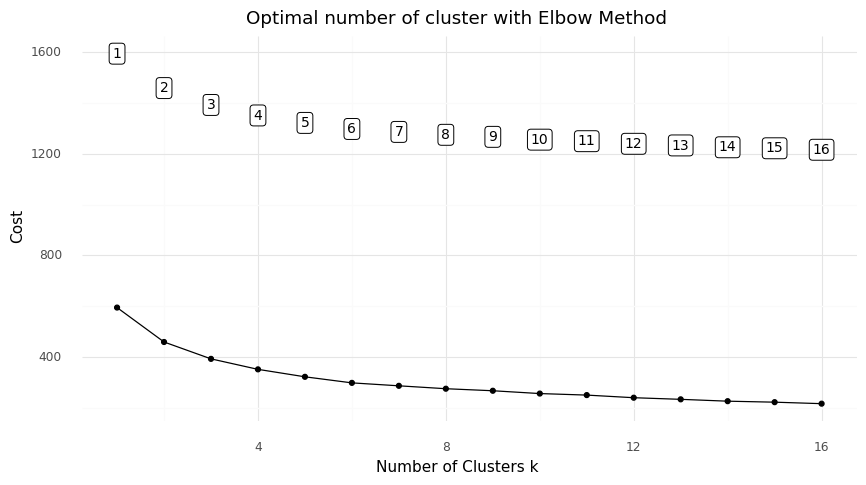

<ggplot: (157873447587)>

In [23]:
df_cost = pd.DataFrame({'Cluster':range(1, 17), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (10, 5)
(
        ggplot(data = df_cost)+
        geom_line(aes(x = 'Cluster',
                      y = 'Cost'))+
        geom_point(aes(x = 'Cluster',
                       y = 'Cost'))+
        geom_label(aes(x = 'Cluster',
                       y = 'Cost',
                       label = 'Cluster'),
                   size = 10,
                   nudge_y = 1000) +
        labs(title = 'Optimal number of cluster with Elbow Method')+
        xlab('Number of Clusters k')+
        ylab('Cost')+
        theme_minimal()
)

4가 기준점으로 삼기 적절한것 같은 판단 하에, 4로 군집화를 시도하였다.
모양이 올바르지 않거나, 군집화가 안맞으면 바꾸는게 맞다고 판단.

In [24]:
# k 기준값
k_cluster = 7
# clustering process
kproto = KPrototypes(n_clusters= k_cluster, init='Cao', n_jobs = -1)
clusters = kproto.fit_predict(protodata, categorical=categorical_columns)

범주에 할당된 값은 다음과 같습니다.

In [25]:
pd.Series(clusters).value_counts()

0    235
5    201
3    163
4    144
1    135
6    131
2     98
dtype: int64

그래프 상에서는 다음과 같이 나타납니다.

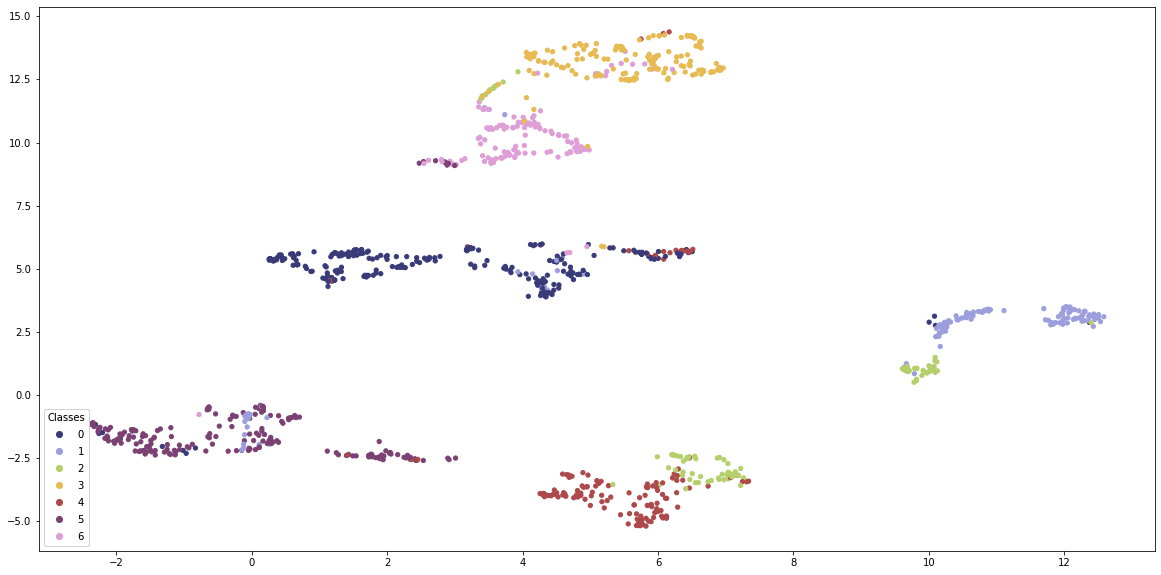

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[0][:, 0], embedding[0][:, 1], s=18, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=k_cluster),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

구성값을 좀 파악해보고 싶은데. 일단 원 데이터 셋에, 분류된 라벨링 값을 부여함.

In [27]:
outputs = data.copy()
outputs['Cluster Labels'] = kproto.labels_

사실 이렇게 봐서는 잘 모르겠다....

In [28]:
outputs[outputs['Cluster Labels']==0].카테고리.value_counts()

BL     80
판타지    43
드라마    42
순정     29
액션     26
일상      8
개그      6
스릴러     1
Name: 카테고리, dtype: int64

In [29]:
outputs[outputs['Cluster Labels']==0].hex1.unique()

array(['#fefcf7', '#f2f5f1', '#fdf8f0', '#fcf2ed', '#c49174', '#f0e8e8',
       '#fdf9f6', '#fbfaf9', '#e3d8e4', '#f6f3f0', '#985d5d', '#f1eef4',
       '#fef2ec', '#f1cbb5', '#6f7866', '#fbeff1', '#fefcfb', '#fdfdf7',
       '#fdebda', '#f1efee', '#f3f7f7', '#f4edf0', '#f0e6d8', '#fffefd',
       '#d7c5c9', '#e4dfdd', '#fce4d8', '#f1e5d3', '#cadee1', '#fcf0e2',
       '#f5f9fa', '#d6c7c2', '#fcfcde', '#7168a0', '#fceae4', '#ddccbf',
       '#fcf7f5', '#fbdee1', '#f6e7d6', '#fefefd', '#fceaea', '#fdf5eb',
       '#e5bdb3', '#f9e2d9', '#efdcd9', '#faf9fa', '#8d9588', '#f0cfc0',
       '#c1a4b1', '#eef5e8', '#f5e5e5', '#d2a9bb', '#fcf8f3', '#f9f7f1',
       '#dcbfb0', '#fdfafb', '#b05555', '#f9d180', '#f4f8fb', '#f8e5dc',
       '#fefaf9', '#eceff1', '#f0e5ea', '#ccb3af', '#c3d2ed', '#f9f1e9',
       '#837c67', '#dab8ba', '#f7ede7', '#fafdfd', '#fef8ec', '#f5f3f6',
       '#b3808f', '#f9eeee', '#f5c7d2', '#f0cca4', '#cdcceb', '#f9e6d5',
       '#e5eced', '#f9f8f4', '#e4c4b1', '#f8f0e2', 

아니 진짜로... 진짜 모르겠으니까 폴더별로 정리해서 그림 묶음 확인하자.
여기서부터는 실행 안한 코드라서 잘 돌아가는지 모름.

In [30]:
# 기존 작업에서 실시하였다면,
# 기존에 존재하는 값또한 지워야 하기 때문에, os.rmdir을 사용하지 못합니다.
if os.path.exists('KPrototypes_Output_images'):
    shutil.rmtree('KPrototypes_Output_images')

# 다시 폴더를 만들어줍니다.
os.mkdir('KPrototypes_Output_images')
for i in range(k_cluster):
    os.mkdir('KPrototypes_Output_images/'+str(i)+'_cluster')

폴더를 만들었으니, 이제 해당하는 위치에, 파일을 집어넣기만 하면 된다.
앞서 그림 색상에서, path를 포함하는 k-mean 파일을 새로 만들었으므로, 그 위치 참조.

아래 코드로 클러스터 폴더에 복사-저장되어 정리되겠다.

In [31]:
for idx in tqdm(outputs.index):
    line = outputs.loc[idx]
    # 복사할 파일의 위치 - 상대경로.
    file_from = str(line.카테고리) + '/' + str(line.file_path)
    # 도착위치.
    file_to = 'KPrototypes_Output_images/' + str(line['Cluster Labels']) +'_cluster/' +str(line.file_path)

    shutil.copyfile(file_from, file_to)

100%|██████████| 1107/1107 [00:04<00:00, 242.23it/s]


센트로이드 중심점.

In [32]:
# Cluster centorid
kproto.cluster_centroids_

array([['0.001118580709652262', '0.00047241260865603287',
        '0.9142261159783062', '0.0012599222068816068',
        '0.0008258227309542872', '0.8283521068001652',
        '0.001484469095439729', '0.0010552552111382446',
        '0.7254901960784309', '0.0016112065073706533',
        '0.0011646033472811023', '0.6625615352523987',
        '0.0020758204776615665', '0.001380302857556289',
        '0.2894284522319568', 'BL'],
       ['0.0010660218466711263', '0.0004701880846222755',
        '0.9308641975308635', '0.001234514913682552',
        '0.0008702943874956754', '0.8658242556281763',
        '0.002318407087079635', '0.0012299099575635807',
        '0.29705156136528793', '0.0016901913407391211',
        '0.001143102917504123', '0.6250689905591849',
        '0.0014960277874590134', '0.001392480219678112',
        '0.6523166303558462', '순정'],
       ['0.0013175771405924655', '0.0007327815813666431',
        '0.8493397358943573', '0.002166954589277029',
        '0.001443283442603103',

In [33]:
import colorsys
# colorsys.hsv_to_rgb(h, s, v)
cent = pd.DataFrame(kproto.cluster_centroids_)

cent = pd.concat([(cent.iloc[:,0:3].astype('float')*255),(cent.iloc[:,3:6].astype('float')*255),
                  (cent.iloc[:,6:9].astype('float')*255),(cent.iloc[:,9:12].astype('float')*255),
                  (cent.iloc[:,12:15].astype('float')*255)], axis = 1)

cent = cent.to_numpy()

cent

array([[2.85238081e-01, 1.20465215e-01, 2.33127660e+02, 3.21280163e-01,
        2.10584796e-01, 2.11229787e+02, 3.78539619e-01, 2.69090079e-01,
        1.85000000e+02, 4.10857659e-01, 2.96973854e-01, 1.68953191e+02,
        5.29334222e-01, 3.51977229e-01, 7.38042553e+01],
       [2.71835571e-01, 1.19897962e-01, 2.37370370e+02, 3.14801303e-01,
        2.21925069e-01, 2.20785185e+02, 5.91193807e-01, 3.13627039e-01,
        7.57481481e+01, 4.30998792e-01, 2.91491244e-01, 1.59392593e+02,
        3.81487086e-01, 3.55082456e-01, 1.66340741e+02],
       [3.35982171e-01, 1.86859303e-01, 2.16581633e+02, 5.52573420e-01,
        3.68037278e-01, 8.40918367e+01, 5.19923099e-01, 3.63666517e-01,
        8.25714286e+01, 3.42886050e-01, 2.81436205e-01, 1.98846939e+02,
        3.58834887e-01, 3.27047556e-01, 1.99581633e+02],
       [4.98134462e-01, 3.67271863e-01, 5.03190184e+01, 4.67853321e-01,
        3.25848173e-01, 8.21656442e+01, 3.76131418e-01, 2.62135906e-01,
        1.65036810e+02, 3.06324276e-0

센트로이드 중심값은 다음과 같이 학습되었다.

In [34]:
hex1c = []
hex2c = []
hex3c = []
hex4c = []
hex5c = []
for i in range(k_cluster):
    r, g, b = colorsys.hsv_to_rgb(cent[i, 0:3][0], cent[i, 0:3][1], cent[i, 0:3][2])
    r = int(r); g = int(g); b = int(b)
    hex1c.append((r,g,b))
    r, g, b = colorsys.hsv_to_rgb(cent[i, 3:6][0], cent[i, 3:6][1], cent[i, 3:6][2])
    r = int(r); g = int(g); b = int(b)
    hex2c.append((r,g,b))
    r, g, b = colorsys.hsv_to_rgb(cent[i, 6:9][0], cent[i, 6:9][1], cent[i, 6:9][2])
    r = int(r); g = int(g); b = int(b)
    hex3c.append((r,g,b))
    r, g, b = colorsys.hsv_to_rgb(cent[i, 9:12][0], cent[i, 9:12][1], cent[i, 9:12][2])
    r = int(r); g = int(g); b = int(b)
    hex4c.append((r,g,b))
    r, g, b = colorsys.hsv_to_rgb(cent[i, 12:15][0], cent[i, 12:15][1], cent[i, 12:15][2])
    r = int(r); g = int(g); b = int(b)
    hex5c.append((r,g,b))


cent = pd.DataFrame([hex1c,hex2c,hex3c,hex4c,hex5c])
cent = cent.T
# 이 형태가, 상위 5개 색상의 데이터인것이지.
cent
# hex5c.append(colorsys.hsv_to_rgb(cent[i, 12:15][0], cent[i, 12:15][1], cent[i, 12:15][2]))

,0,1,2,3,4
0,"(213, 233, 205)","(169, 211, 166)","(135, 184, 148)","(118, 168, 142)","(47, 69, 73)"
1,"(219, 237, 208)","(177, 220, 171)","(51, 62, 75)","(112, 159, 140)","(107, 166, 124)"
2,"(176, 216, 176)","(53, 74, 84)","(52, 78, 82)","(142, 198, 146)","(134, 199, 144)"
3,"(31, 50, 50)","(55, 82, 77)","(121, 165, 132)","(146, 186, 138)","(148, 195, 144)"
4,"(207, 237, 200)","(46, 58, 69)","(154, 208, 157)","(115, 171, 141)","(101, 159, 145)"
5,"(200, 231, 199)","(154, 202, 157)","(132, 187, 142)","(43, 62, 63)","(113, 178, 140)"
6,"(35, 56, 58)","(178, 223, 183)","(114, 169, 149)","(110, 165, 132)","(111, 176, 153)"


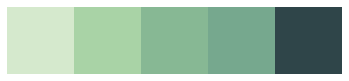

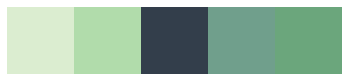

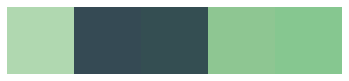

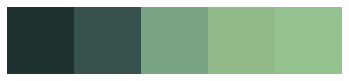

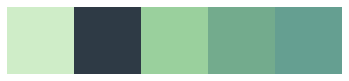

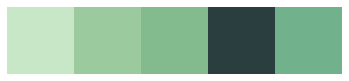

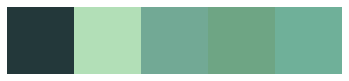

In [35]:

for i in range(cent.shape[0]):
    rgb_list = list(cent.iloc[i])
    one_px = np.array(rgb_list)[np.newaxis, :, :]

    plt.imshow(np.array(one_px));
    plt.axis('off');
    plt.show();

    # plt.savefig(str(i)+'_cluster_centroids.png')


고장났니? 아닌데...

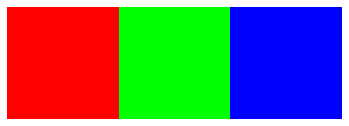

In [36]:
rgb_list = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
one_px = np.array(rgb_list)[np.newaxis, :, :]

plt.imshow(np.array(one_px));
plt.axis('off');
plt.show();

In [37]:
os.getcwd()

'C:\\Users\\styli\\Desktop\\github_repository_add\\OneStore_webtoon_img_cluster'